In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.compose import make_column_selector as selector #Para seleccionar de forma automática las variables numéricas y categóricas
from sklearn.preprocessing import OneHotEncoder #Para codificar las variables categóricas usando dummies
from sklearn.preprocessing import StandardScaler #Para normalizar las variables numéricas
from sklearn.compose import ColumnTransformer #Modifica las columnas usando los preprocesadores
from sklearn.pipeline import make_pipeline #Planifica una secuencia de procesos
from sklearn import set_config #Para mostrar graficamente el pipeline
from sklearn.model_selection import GridSearchCV

set_config(display='diagram')
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

df = pd.read_csv('../../data/Accidentes_2013_2023.csv')
df

,año,fall_les,tipo_veh,modelo_veh,g_modelo_veh,marca,color,hora_ocu_fall,g_hora_fall,g_hora_5_fall,día_sem_ocu_fall,mes_ocu_fall,causa_acc
0,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
1,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
2,2013,Lesionado,Automóvil,2010-2019,ignorado,Avanti,Blanco,5,00:00 a 05:59,ignorado,Martes,Enero,Choque
3,2013,Fallecido,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
4,2013,Lesionado,Motocicleta,2010-2019,ignorado,Great Wall,Rojo,Ignorado,00:00 a 05:59,ignorado,Martes,Enero,Choque
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99510,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99511,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99512,2020,Lesionado,Motocicleta,Ignorado,Ignorado,TVS Apache,Negro,13,12:00 a 17:59,Tarde,Jueves,Diciembre,Atropello
99513,2020,Fallecido,Motocicleta,2019,2010-2019,MRT,Rojo,18,18:00 a 23:59,Noche,Jueves,Diciembre,Atropello


# Limpieza de datos

In [35]:
# Eliminar filas donde 'fall_les' es NaN
df = df.dropna(subset=['fall_les'])

# Confirmar que se eliminaron
print("Valores faltantes por columna después de limpiar:")
print(df.isna().sum())

print("\nDistribución de clases en 'fall_les':")
print(df['fall_les'].value_counts())

Valores faltantes por columna después de limpiar:
año                 0
fall_les            0
tipo_veh            0
modelo_veh          0
 g_modelo_veh       0
marca               0
color               0
hora_ocu_fall       0
g_hora_fall         0
g_hora_5_fall       0
día_sem_ocu_fall    0
mes_ocu_fall        0
causa_acc           0
dtype: int64

Distribución de clases en 'fall_les':
fall_les
Lesionado    64038
Fallecido    12911
Name: count, dtype: int64


In [36]:
y = df.pop("fall_les")

print(y)
print(df.head())

0        Lesionado
1        Lesionado
2        Lesionado
3        Fallecido
4        Lesionado
           ...    
99510    Lesionado
99511    Lesionado
99512    Lesionado
99513    Fallecido
99514    Lesionado
Name: fall_les, Length: 76949, dtype: object
    año     tipo_veh modelo_veh  g_modelo_veh       marca   color  \
0  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
1  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
2  2013    Automóvil  2010-2019      ignorado      Avanti  Blanco   
3  2013  Motocicleta  2010-2019      ignorado  Great Wall    Rojo   
4  2013  Motocicleta  2010-2019      ignorado  Great Wall    Rojo   

  hora_ocu_fall    g_hora_fall g_hora_5_fall día_sem_ocu_fall mes_ocu_fall  \
0             5  00:00 a 05:59      ignorado           Martes        Enero   
1             5  00:00 a 05:59      ignorado           Martes        Enero   
2             5  00:00 a 05:59      ignorado           Martes        Enero   
3      Ignorado  00

# Entrenamiento y Pruebas

In [37]:
X = df #El resto de los datos

# Separar variables categóricas y numéricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

random.seed(123)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53864 entries, 63905 to 16312
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   año               53864 non-null  int64 
 1   tipo_veh          53864 non-null  object
 2   modelo_veh        53864 non-null  object
 3    g_modelo_veh     53864 non-null  object
 4   marca             53864 non-null  object
 5   color             53864 non-null  object
 6   hora_ocu_fall     53864 non-null  object
 7   g_hora_fall       53864 non-null  object
 8   g_hora_5_fall     53864 non-null  object
 9   día_sem_ocu_fall  53864 non-null  object
 10  mes_ocu_fall      53864 non-null  object
 11  causa_acc         53864 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.3+ MB


In [40]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23085 entries, 91589 to 34567
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   año               23085 non-null  int64 
 1   tipo_veh          23085 non-null  object
 2   modelo_veh        23085 non-null  object
 3    g_modelo_veh     23085 non-null  object
 4   marca             23085 non-null  object
 5   color             23085 non-null  object
 6   hora_ocu_fall     23085 non-null  object
 7   g_hora_fall       23085 non-null  object
 8   g_hora_5_fall     23085 non-null  object
 9   día_sem_ocu_fall  23085 non-null  object
 10  mes_ocu_fall      23085 non-null  object
 11  causa_acc         23085 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.3+ MB


# Buscar mejores parametros para las redes neuronales

In [41]:
# 3. Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# 4. Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlpclassifier', MLPClassifier())
])

# 5. Grid de parámetros
parametros_tun = {
    'mlpclassifier__max_iter': [100, 200, 500],
    'mlpclassifier__learning_rate_init': [0.01, 0.1, 1],
    'mlpclassifier__hidden_layer_sizes': [(3, 2), (5, 3), (10, 2)]
}

# 6. GridSearchCV
model_grid_search = GridSearchCV(pipeline, param_grid=parametros_tun, n_jobs=2, cv=10, verbose=1)
model_grid_search.fit(X_train, y_train)

# 7. Mejor modelo y predicciones
print("Mejores parámetros:", model_grid_search.best_params_)
y_pred = model_grid_search.predict(X_test)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejores parámetros: {'mlpclassifier__hidden_layer_sizes': (5, 3), 'mlpclassifier__learning_rate_init': 0.1, 'mlpclassifier__max_iter': 200}


## Validacion cruzada

In [49]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Validación cruzada sobre el mejor modelo
best_model = model_grid_search.best_estimator_

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro'),
    'f1': make_scorer(f1_score, average='micro')
}

cv_results = cross_validate(best_model, X, y, cv=cv, scoring=scoring)

print("\nValidación cruzada (10-fold):")
print("Accuracy promedio:", np.mean(cv_results['test_accuracy']))
print("Precision promedio:", np.mean(cv_results['test_precision']))
print("Recall promedio:", np.mean(cv_results['test_recall']))
print("F1-score promedio:", np.mean(cv_results['test_f1']))


Validación cruzada (10-fold):
Accuracy promedio: 0.8547739874095794
Precision promedio: 0.8547739874095794
Recall promedio: 0.8547739874095794
F1-score promedio: 0.8547739874095794


## Entrenarlo

In [50]:
y_pred = best_model.predict(X_test)
print(y_pred)

['Lesionado' 'Lesionado' 'Lesionado' ... 'Lesionado' 'Lesionado'
 'Lesionado']


# Curva de perdida

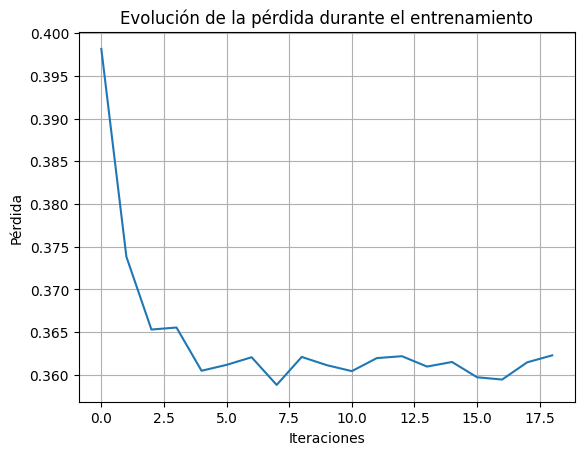

In [51]:
plt.plot(best_model.named_steps['mlpclassifier'].loss_curve_)
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

# Matriz de confusion

Accuracy:  0.8570067143166559
Precision:  0.8570067143166559
recall:  0.8570067143166559
F1-score: 0.8570067143166559


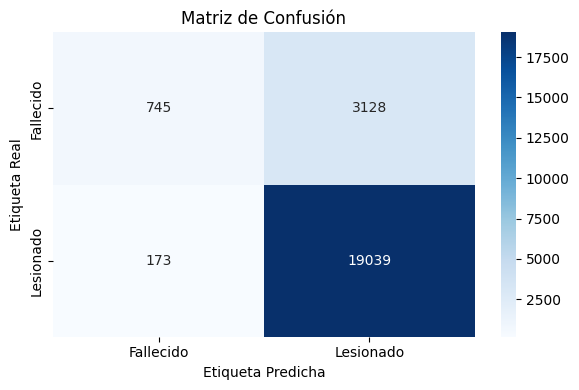

In [54]:
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
precision =precision_score(y_test, y_pred,average='micro')
recall =  recall_score(y_test, y_pred,average='micro')
f1 = f1_score(y_test,y_pred,average='micro')
print('Accuracy: ',accuracy)
print('Precision: ', precision)
print('recall: ',recall)
print('F1-score:', f1)

labels = best_model.classes_  # Obtiene los nombres de las clases desde el modelo

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
plt.show()